In [2]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc
import joblib
import os
from tqdm import tqdm
from dataloader import get_dataloaders

In [3]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_labels, num_heads=4, num_layers=2, hidden_dim=512):
        super(TransformerClassifier, self).__init__()
        
        # Project input to the hidden dimension
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, 
            nhead=num_heads, 
            dim_feedforward=hidden_dim * 2, 
            dropout=0.3, 
            activation='relu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.fc = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.input_proj(x)  # Project input to match transformer dimensions
        x = x.unsqueeze(1)  # Add sequence dimension (batch_size, seq_len=1, hidden_dim)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)  # Remove sequence dimension
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, scheduler, num_epochs=50, patience=5):
    best_val_loss = float("inf")
    early_stop_counter = 0
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")
        
        # Early Stopping & Model Saving
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            os.makedirs("./models", exist_ok=True)
            torch.save(model.state_dict(), "./models/best_transformer_model.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
    
    return train_losses, val_losses

In [5]:
# Evaluation Function
def evaluate_model(model, data_loader, device):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred), np.array(y_scores)

In [16]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, name):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes)
    plt.title(f"Transformer Confusion Matrix - {name}")
    plt.show()

In [17]:
# Plot ROC Curve
def plot_roc_curve(y_true, y_scores, classes, name):
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Neural Network ROC Curve - {name}")
    plt.legend()
    plt.show()


In [8]:
# Dataloader
structural_csv = "./data/merged/processed_urls.csv"
embeddings_csv = "./data/merged/url_embeddings.csv"
train_loader, val_loader, test_loader = get_dataloaders(structural_csv, embeddings_csv, merge_embeddings=True)

In [9]:
# Define Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = next(iter(train_loader))[0].shape[1]
num_classes = len(set(next(iter(train_loader))[1].numpy()))
model = TransformerClassifier(input_dim=input_dim, num_labels=num_classes)
model.to(device)

c:\Users\sarim\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerClassifier(
  (input_proj): Linear(in_features=779, out_features=512, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [10]:
# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 50
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Train Model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, scheduler)

Epoch 1/50:   0%|          | 0/1491 [00:00<?, ?it/s]c:\Users\sarim\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1/50: 100%|██████████| 1491/1491 [01:01<00:00, 24.14it/s]


Epoch 1: Train Loss = 0.7256, Val Loss = 0.3994


Epoch 2/50: 100%|██████████| 1491/1491 [00:59<00:00, 24.88it/s]


Epoch 2: Train Loss = 0.3794, Val Loss = 0.2860


Epoch 3/50: 100%|██████████| 1491/1491 [00:55<00:00, 26.64it/s]


Epoch 3: Train Loss = 0.3127, Val Loss = 0.2473


Epoch 4/50: 100%|██████████| 1491/1491 [01:07<00:00, 22.12it/s]


Epoch 4: Train Loss = 0.2819, Val Loss = 0.2411


Epoch 5/50: 100%|██████████| 1491/1491 [01:09<00:00, 21.34it/s]


Epoch 5: Train Loss = 0.2574, Val Loss = 0.2185


Epoch 6/50: 100%|██████████| 1491/1491 [01:02<00:00, 23.78it/s]


Epoch 6: Train Loss = 0.2425, Val Loss = 0.2049


Epoch 7/50: 100%|██████████| 1491/1491 [00:58<00:00, 25.46it/s]


Epoch 7: Train Loss = 0.2285, Val Loss = 0.2020


Epoch 8/50: 100%|██████████| 1491/1491 [00:59<00:00, 25.12it/s]


Epoch 8: Train Loss = 0.2197, Val Loss = 0.1878


Epoch 9/50: 100%|██████████| 1491/1491 [00:59<00:00, 25.04it/s]


Epoch 9: Train Loss = 0.2070, Val Loss = 0.1836


Epoch 10/50: 100%|██████████| 1491/1491 [00:59<00:00, 25.11it/s]


Epoch 10: Train Loss = 0.1989, Val Loss = 0.1833


Epoch 11/50: 100%|██████████| 1491/1491 [00:54<00:00, 27.60it/s]


Epoch 11: Train Loss = 0.1937, Val Loss = 0.1739


Epoch 12/50: 100%|██████████| 1491/1491 [00:57<00:00, 25.91it/s]


Epoch 12: Train Loss = 0.1853, Val Loss = 0.1671


Epoch 13/50: 100%|██████████| 1491/1491 [00:55<00:00, 27.09it/s]


Epoch 13: Train Loss = 0.1777, Val Loss = 0.1653


Epoch 14/50: 100%|██████████| 1491/1491 [00:57<00:00, 26.04it/s]


Epoch 14: Train Loss = 0.1719, Val Loss = 0.1570


Epoch 15/50: 100%|██████████| 1491/1491 [01:07<00:00, 22.13it/s]


Epoch 15: Train Loss = 0.1671, Val Loss = 0.1684


Epoch 16/50: 100%|██████████| 1491/1491 [01:01<00:00, 24.33it/s]


Epoch 16: Train Loss = 0.1621, Val Loss = 0.1598


Epoch 17/50: 100%|██████████| 1491/1491 [01:03<00:00, 23.51it/s]


Epoch 17: Train Loss = 0.1569, Val Loss = 0.1569


Epoch 18/50: 100%|██████████| 1491/1491 [00:53<00:00, 28.04it/s]


Epoch 18: Train Loss = 0.1517, Val Loss = 0.1514


Epoch 19/50: 100%|██████████| 1491/1491 [00:52<00:00, 28.57it/s]


Epoch 19: Train Loss = 0.1497, Val Loss = 0.1462


Epoch 20/50: 100%|██████████| 1491/1491 [00:53<00:00, 27.78it/s]


Epoch 20: Train Loss = 0.1466, Val Loss = 0.1531


Epoch 21/50: 100%|██████████| 1491/1491 [00:52<00:00, 28.36it/s]


Epoch 21: Train Loss = 0.1429, Val Loss = 0.1477


Epoch 22/50: 100%|██████████| 1491/1491 [00:52<00:00, 28.53it/s]


Epoch 22: Train Loss = 0.1396, Val Loss = 0.1481


Epoch 23/50: 100%|██████████| 1491/1491 [00:52<00:00, 28.54it/s]


Epoch 23: Train Loss = 0.1350, Val Loss = 0.1520


Epoch 24/50: 100%|██████████| 1491/1491 [00:53<00:00, 28.06it/s]


Epoch 24: Train Loss = 0.1325, Val Loss = 0.1525
Early stopping triggered.


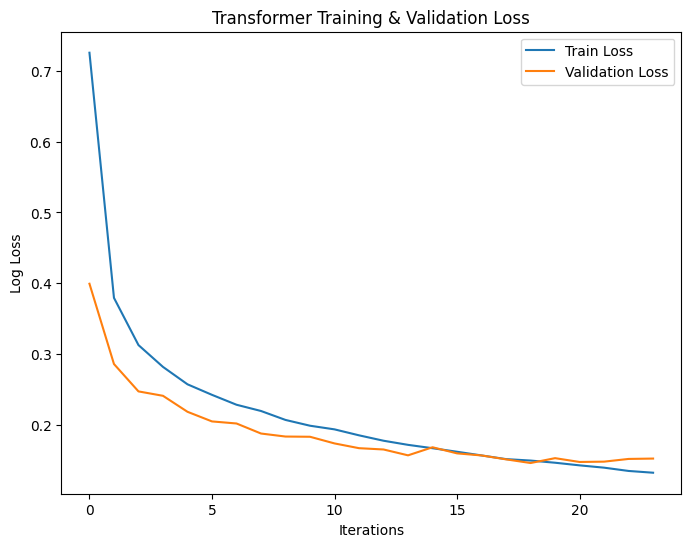

In [12]:
# ========== PLOT TRAINING LOSS ==========

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.legend()
plt.title("Transformer Training & Validation Loss")
plt.show()

In [13]:
 # Load Best Model
model.load_state_dict(torch.load("./models/best_transformer_model.pth"))

C:\Users\sarim\AppData\Local\Temp\ipykernel_35256\3360648669.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/best_transformer_

<All keys matched successfully>


📊 Transformer Classification Report for Train:
              precision    recall  f1-score   support

      benign       0.93      0.95      0.94      9597
  defacement       0.97      0.98      0.98      9499
     malware       0.98      0.94      0.96      9508
    phishing       0.90      0.91      0.91      9571
        spam       0.99      1.00      1.00      9510

    accuracy                           0.96     47685
   macro avg       0.96      0.96      0.96     47685
weighted avg       0.96      0.96      0.96     47685



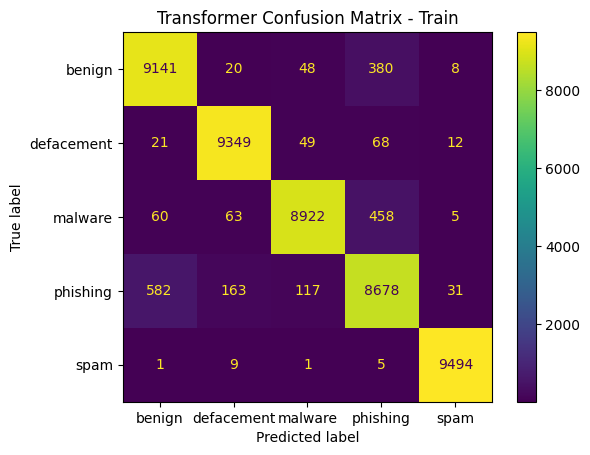

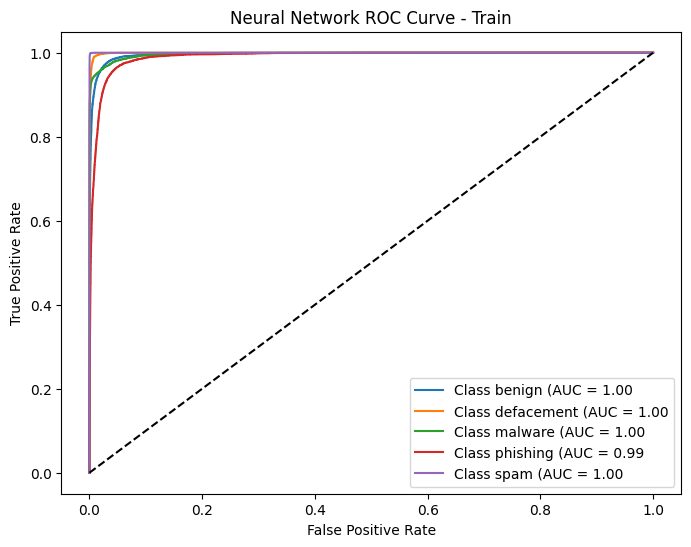


📊 Transformer Classification Report for Val:
              precision    recall  f1-score   support

      benign       0.92      0.96      0.94      1135
  defacement       0.98      0.98      0.98      1230
     malware       0.98      0.93      0.95      1210
    phishing       0.90      0.90      0.90      1168
        spam       0.99      1.00      1.00      1217

    accuracy                           0.95      5960
   macro avg       0.95      0.95      0.95      5960
weighted avg       0.95      0.95      0.95      5960



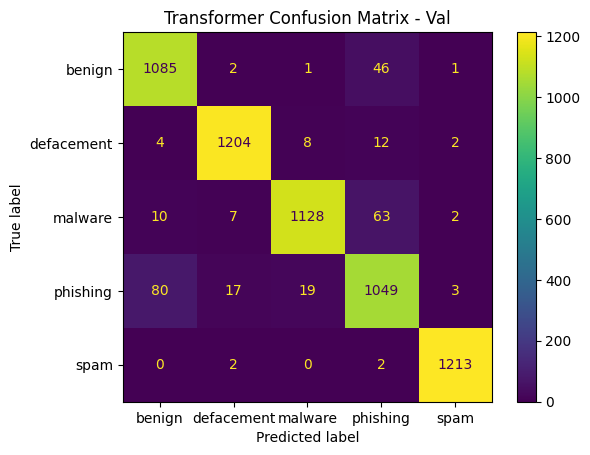

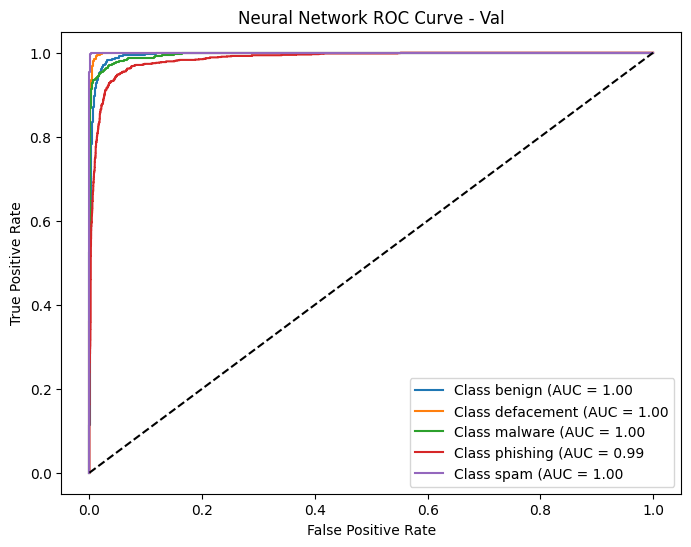


📊 Transformer Classification Report for Test:
              precision    recall  f1-score   support

      benign       0.92      0.94      0.93      1189
  defacement       0.95      0.97      0.96      1192
     malware       0.97      0.93      0.95      1203
    phishing       0.89      0.87      0.88      1182
        spam       0.99      0.99      0.99      1194

    accuracy                           0.94      5960
   macro avg       0.94      0.94      0.94      5960
weighted avg       0.94      0.94      0.94      5960



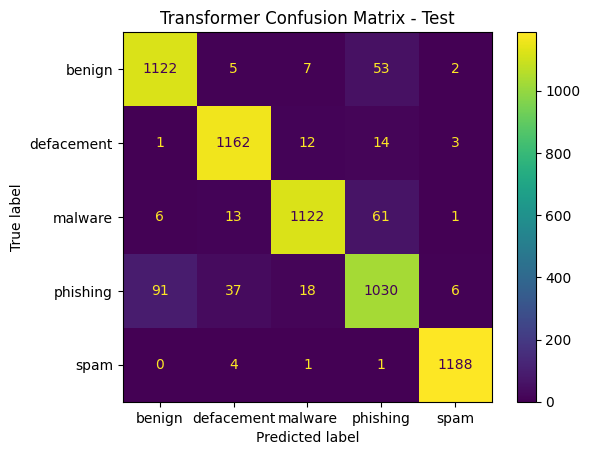

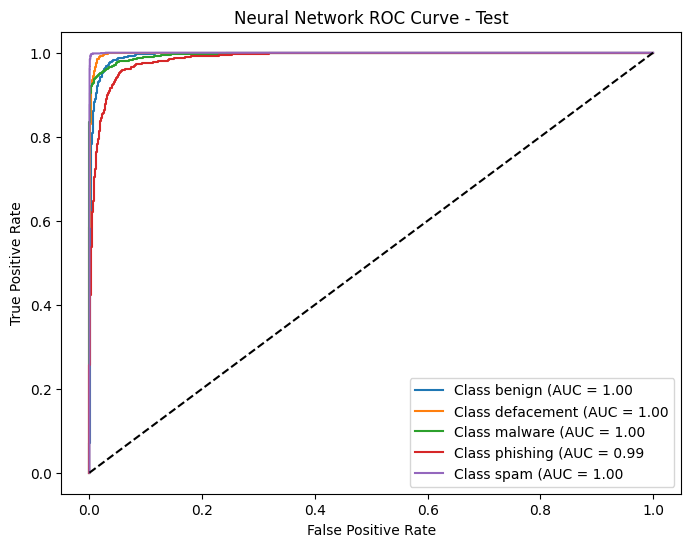

In [19]:
loaders = { "Train" : train_loader, "Val" : val_loader, "Test" : test_loader }
label_mapping = {0: 'benign', 1: 'defacement', 2: 'malware', 3: 'phishing', 4: 'spam'}

for name, loader in loaders.items():
    
    # Evaluate on Test Set
    y_true, y_pred, y_scores = evaluate_model(model, loader, device)

    class_names = list(label_mapping.values())

    print(f"\n📊 Transformer Classification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, class_names, name)
    
    # Plot ROC Curve
    plot_roc_curve(y_true, y_scores, class_names, name)